In [34]:
import eispac
import numpy as np
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
import pandas as pd
import os
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord)
import shapely
from scipy.io import readsav
import scipy.interpolate
from astropy.visualization import (ImageNormalize, SqrtStretch, 
                                   AsinhStretch, LogStretch)
from eis_straylight import calc_short_range_stray_light, calc_long_range_stray_light_aia_eis, coalign_eis_aia
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc_context
import cmcrameri.cm as cmcm

In [3]:
ms_style_dict = {'text.usetex': True, 'font.family': 'serif', 'axes.linewidth': 1.2,
                 'xtick.major.width': 1.2, 'xtick.major.size': 4,
                 'ytick.major.width': 1.2, 'ytick.major.size': 4,
                 'xtick.minor.width': 1.2, 'xtick.minor.size': 2,
                 'ytick.minor.width': 1.2, 'ytick.minor.size': 2,
                 'xtick.direction': 'in', 'ytick.direction': 'in',
                 'text.latex.preamble': r'\usepackage[T1]{fontenc}'
                 r'\usepackage{amsmath}' r'\usepackage{siunitx}'
                 r'\sisetup{detect-all=True}' r'\usepackage{fixltx2e}'}

In [65]:
eis_195_intmap_shift_1024 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_intmap_shift.fits")
eis_195_intmap_shift_1024.plot_settings['aspect'] = eis_195_intmap_shift_1024.scale.axis2/eis_195_intmap_shift_1024.scale.axis1
# eis_195_intmap_shift_1024.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=1e3)
eis_195_intmap_shift_1024.plot_settings['cmap'] = 'sdoaia193'
eis_195_velmap_shift_1024 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_shift.fits")
eis_195_velmap_shift_1024.plot_settings['aspect'] = eis_195_velmap_shift_1024.scale.axis2/eis_195_velmap_shift_1024.scale.axis1
eis_195_velmap_shift_1024.plot_settings['norm'] = ImageNormalize(vmin=-20,vmax=20)
eis_195_velmap_shift_1024.plot_settings['cmap'] = 'coolwarm'

In [66]:
eis_195_intmap_shift_1020 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_intmap_shift.fits")
eis_195_intmap_shift_1020.plot_settings['aspect'] = eis_195_intmap_shift_1020.scale.axis2/eis_195_intmap_shift_1020.scale.axis1
# eis_195_intmap_shift_1020.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=1e3)
eis_195_intmap_shift_1020.plot_settings['cmap'] = 'sdoaia193'

eis_195_velmap_shift_1020 = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_velmap_shift.fits")
eis_195_velmap_shift_1020.plot_settings['aspect'] = eis_195_velmap_shift_1020.scale.axis2/eis_195_velmap_shift_1020.scale.axis1
eis_195_velmap_shift_1020.plot_settings['norm'] = ImageNormalize(vmin=-20,vmax=20)
eis_195_velmap_shift_1020.plot_settings['cmap'] = 'coolwarm'

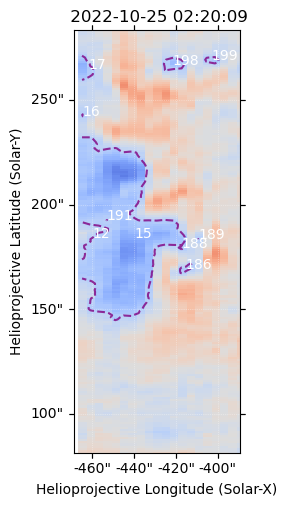

In [29]:
fig = plt.figure()

ax = fig.add_subplot(111, projection=eis_195_velmap_shift_1024)
eis_195_velmap_shift_1024.plot(axes=ax)

cs_eis_1024 = eis_195_velmap_shift_1024.draw_contours(levels=[-5,],colors=["purple"],axes=ax,alpha=0.8)

ax.set_xlim(0,20)
ax.set_ylim(150,350)

for ii, seg in enumerate(cs_eis_1024.allsegs[0]):
    if np.nanmean(seg, axis=0)[0] > 0 and np.nanmean(seg, axis=0)[0] < 20 and \
        np.nanmean(seg, axis=0)[1] > 150 and np.nanmean(seg, axis=0)[1] < 350:
        ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)


plt.subplots_adjust(bottom=0.0)

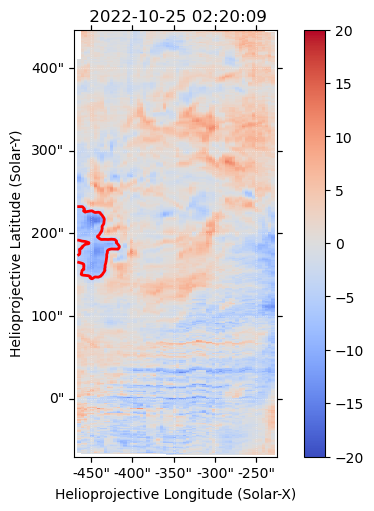

In [52]:
cs_selected_index_1024 = [12,15]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_195_velmap_shift_1024)
eis_195_velmap_shift_1024.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index_1024:
    ax.plot(*cs_eis_1024.allsegs[0][ii].T, color='red', lw=2)

In [53]:
cs_skycoords_eis_1024 = [eis_195_velmap_shift_1024.pixel_to_world(np.concatenate((cs_eis_1024.allsegs[0][cs_selected_index_1024[0]][:,0],
                                                                    cs_eis_1024.allsegs[0][cs_selected_index_1024[1]][:,0]))*u.pix,
                                                    np.concatenate((cs_eis_1024.allsegs[0][cs_selected_index_1024[0]][:,1],
                                                                    cs_eis_1024.allsegs[0][cs_selected_index_1024[1]][:,1]))*u.pix) \
                ]
cs_regions_eis_1024 = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords_eis_1024]

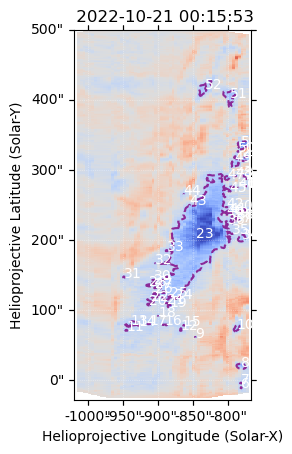

In [51]:
fig = plt.figure()

ax = fig.add_subplot(111, projection=eis_195_velmap_shift_1020)
eis_195_velmap_shift_1020.plot(axes=ax)

cs_eis_1020 = eis_195_velmap_shift_1020.draw_contours(levels=[-5,],colors=["purple"],axes=ax,alpha=0.8)


for ii, seg in enumerate(cs_eis_1020.allsegs[0]):
    ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

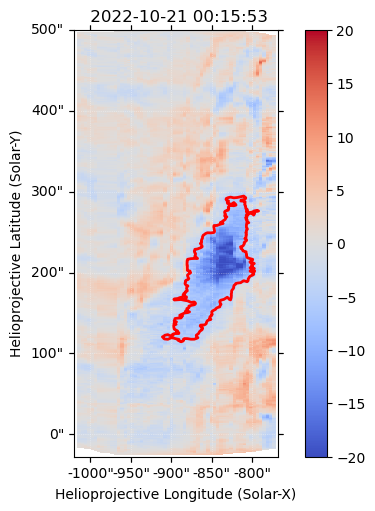

In [54]:
cs_selected_index_1020 = [23]
    
fig = plt.figure(figsize=(7, 5),layout='constrained')
ax = fig.add_subplot(111, projection=eis_195_velmap_shift_1020)
eis_195_velmap_shift_1020.plot(axes=ax)
plt.colorbar()

for ii in cs_selected_index_1020:
    ax.plot(*cs_eis_1020.allsegs[0][ii].T, color='red', lw=2)

In [56]:
cs_skycoords_eis_1020 = [eis_195_velmap_shift_1020.pixel_to_world(cs_eis_1020.allsegs[0][cs_selected_index_1020[0]][:,0]*u.pix,
                                                    cs_eis_1020.allsegs[0][cs_selected_index_1020[0]][:,1]*u.pix) \
                ]
cs_regions_eis_1020 = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords_eis_1020]

In [78]:
eis_195_intmap_shift_1024_crop = eis_195_intmap_shift_1024.submap(SkyCoord(eis_195_intmap_shift_1024.bottom_left_coord.Tx,
                                                                           100*u.arcsec, frame=eis_195_intmap_shift_1024.coordinate_frame),
                                                                  top_right=SkyCoord(eis_195_intmap_shift_1024.top_right_coord.Tx,
                                                                            400*u.arcsec, frame=eis_195_intmap_shift_1024.coordinate_frame))
eis_195_intmap_shift_1024_crop.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(eis_195_intmap_shift_1024_crop.data, 1),
                                                                      vmax=np.nanpercentile(eis_195_intmap_shift_1024_crop.data, 99),
                                                                      stretch=AsinhStretch())

eis_195_velmap_shift_1024_crop = eis_195_velmap_shift_1024.submap(SkyCoord(eis_195_velmap_shift_1024.bottom_left_coord.Tx,
                                                                            100*u.arcsec, frame=eis_195_velmap_shift_1024.coordinate_frame),
                                                                    top_right=SkyCoord(eis_195_velmap_shift_1024.top_right_coord.Tx,
                                                                            400*u.arcsec, frame=eis_195_velmap_shift_1024.coordinate_frame))

eis_195_intmap_shift_1020_crop = eis_195_intmap_shift_1020.submap(SkyCoord(eis_195_intmap_shift_1020.bottom_left_coord.Tx,
                                                                                100*u.arcsec, frame=eis_195_intmap_shift_1020.coordinate_frame),
                                                                        top_right=SkyCoord(eis_195_intmap_shift_1020.top_right_coord.Tx,
                                                                                 400*u.arcsec, frame=eis_195_intmap_shift_1020.coordinate_frame))
eis_195_intmap_shift_1020_crop.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(eis_195_intmap_shift_1020_crop.data, 1),
                                                                      vmax=np.nanpercentile(eis_195_intmap_shift_1020_crop.data, 99),
                                                                      stretch=AsinhStretch())

eis_195_velmap_shift_1020_crop = eis_195_velmap_shift_1020.submap(SkyCoord(eis_195_velmap_shift_1020.bottom_left_coord.Tx,
                                                                                100*u.arcsec, frame=eis_195_velmap_shift_1020.coordinate_frame),
                                                                        top_right=SkyCoord(eis_195_velmap_shift_1020.top_right_coord.Tx,
                                                                                400*u.arcsec, frame=eis_195_velmap_shift_1020.coordinate_frame))

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


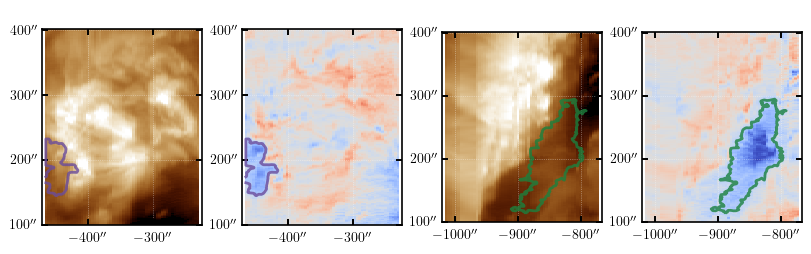

In [79]:
with rc_context(ms_style_dict):
    fig = plt.figure(figsize=(8, 8),layout='constrained')

    ax1 = fig.add_subplot(241, projection=eis_195_intmap_shift_1024_crop)
    eis_195_intmap_shift_1024_crop.plot(axes=ax1)
    ax1.plot_coord(cs_regions_eis_1024[0].vertices, color='#6A4C9C', lw=2,alpha=0.8)

    ax2 = fig.add_subplot(242, projection=eis_195_velmap_shift_1024_crop)
    eis_195_velmap_shift_1024_crop.plot(axes=ax2)
    ax2.plot_coord(cs_regions_eis_1024[0].vertices, color='#6A4C9C', lw=2,alpha=0.8)

    ax3 = fig.add_subplot(243, projection=eis_195_intmap_shift_1020_crop)
    eis_195_intmap_shift_1020_crop.plot(axes=ax3)
    ax3.plot_coord(cs_regions_eis_1020[0].vertices, color='#1B813E', lw=2,alpha=0.8)

    ax4 = fig.add_subplot(244, projection=eis_195_velmap_shift_1020_crop)
    eis_195_velmap_shift_1020_crop.plot(axes=ax4)
    ax4.plot_coord(cs_regions_eis_1020[0].vertices, color='#1B813E', lw=2,alpha=0.8)




    for ax_ in (ax1,ax2,ax3,ax4):
        ax_.coords[0].axislabels.set_visible(False)
        ax_.coords[1].axislabels.set_visible(False)
        ax_.set_title(' ')
        ax_.coords[0].set_ticks(number=4)
        ax_.coords[1].set_ticks(number=4)


    plt.show()